<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/linear_sgd_wd_momentum_adam_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 4.0MB 56.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
from fastai import *
from fastai.vision import *
from statistics import mean, stdev

In [3]:
!pip install ipdb
from ipdb import set_trace as st

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=c9f457f6453c2f24329060af74d130cd406b2601dc81c6eed25e9402eebe0a02
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [4]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [5]:
src = ImageList.from_folder(path/'training').split_by_rand_pct().label_from_folder()

In [6]:
path

PosixPath('/root/.fastai/data/mnist_png')

In [7]:
def resize_img(im_path):
  imd = open_image(im_path).data
  return imd.reshape(1, 28*28*3).squeeze()

In [8]:
#form x_train, y_train, x_valid, y_valid...
path = Path('/root/.fastai/data/mnist_png/training')
path.ls()[0]

PosixPath('/root/.fastai/data/mnist_png/training/3')

In [9]:
#lets just creaete train and valid
train, valid = [], []
counter = 0
rem = 5

for sub_path in path.ls():
  label = sub_path.name
  for im_path in sub_path.ls():
    var = valid if counter % rem == 0 else train
    var.append((resize_img(im_path), label))
    counter += 1

In [10]:
import random
random.shuffle(train), random.shuffle(valid)

x_train, y_train = zip(*train)
x_valid, y_valid = zip(*valid)

def tensorize(iter):
  iter = [i.unsqueeze(0) for i in iter]
  return torch.cat(iter, dim = 0)
  
x_train, x_valid = tensorize(x_train), tensorize(x_valid)

y_train, y_valid = list(map(int, y_train)), list(map(int, y_valid))
y_train, y_valid = torch.Tensor(y_train), torch.Tensor(y_valid)

train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

In [11]:
data = DataBunch.create(train_ds = train_ds, valid_ds = valid_ds, bs = 64)
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fe870f1c390>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fe870f1c3c8>;

Test: None

In [12]:
for x, y in data.train_dl:
  break
x.shape, y.shape

(torch.Size([64, 2352]), torch.Size([64]))

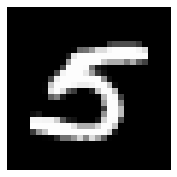

In [13]:
#test
im = x[0].reshape(3, 28, 28)
show_image(im)

In [14]:
loss_func = nn.CrossEntropyLoss()

In [15]:
class MyLinear(nn.Module):
  def __init__(self, ni, no, bias = True):
    super().__init__()
    self.w = nn.Parameter(nn.init.kaiming_normal_(torch.randn(ni, no), a = math.sqrt(5.0)))
    self.b = nn.Parameter(torch.randn(no))
  
  def forward(self, x):
    #x == 64*2352, w = 2352*10
    return x@self.w + self.b

In [16]:
class SingleLinear(nn.Module):
  def __init__(self, ni, no):
    super().__init__()
    self.lin = MyLinear(ni, 500, True)
    self.lin_1 = MyLinear(500, no, True)
    # self.lin_2 = MyLinear(100, no, True)
  
  def forward(self, x):
    # res = self.lin_2(F.relu(self.lin_1(F.relu(self.lin(x)))))
    res = self.lin_1(F.relu(self.lin(x)))
    return  res

In [17]:
def new_loss(yhat, y):
  return loss_func(yhat, y.long())

In [18]:
def update(x, y, lr = 1e-04, wd = 1e-04):
  opt.zero_grad()
  yhat = model(x)
  loss = new_loss(yhat, y)
  losses.append(loss.item())
  # wsum = 0.
  # for p in model.parameters(): wsum += (p**2).sum()
  # loss += wd * wsum
  loss.backward()
  opt.step()

In [19]:
model = SingleLinear(2352, 10).cuda()
losses = []
opt = optim.SGD(model.parameters(), weight_decay=1e-04, lr = 1e-02)
for x, y in data.train_dl:
  update(x, y, lr = 1e-03)

0.12782835960388184 0.4028713140885035


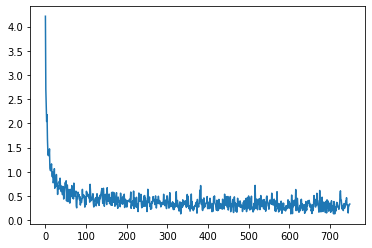

In [20]:
print(min(losses), mean(losses))
plt.plot(losses)

0.10172294080257416 0.4272930147151152


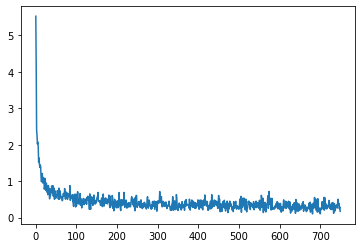

In [83]:
print(min(losses), mean(losses))
plt.plot(losses)

In [24]:
ni, no = 2352, 10

In [21]:
def update(x, y, lr, wd = 0.0):
  yhat = model(x)
  loss = new_loss(yhat, y)

  wsum = 0.
  for p in model.parameters():
    wsum += (p**2).sum()
  if len(losses) % 100 == 0:
    print(wsum, loss, wd*wsum)

  loss += wd*wsum
  loss.backward()
  with torch.no_grad():
    for param in model.parameters():
      param.sub_(lr * param.grad)
      param.grad.zero_()
  losses.append(loss.item())

In [25]:
model = SingleLinear(ni,no).cuda()
losses = []
for x, y in data.train_dl:
  update(x, y, 1e-02, wd = 1e-04)

tensor(1475.0199, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.1180, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.1475, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1475.4824, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.1475, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1475.7009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2976, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.1476, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1475.6788, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3700, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.1476, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1475.5867, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4502, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.1476, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1475.4382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3099, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.147

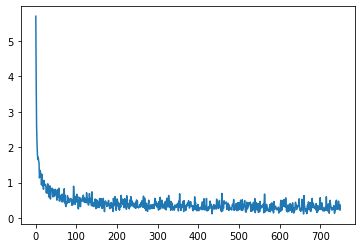

In [96]:
plt.plot(losses) #no wd

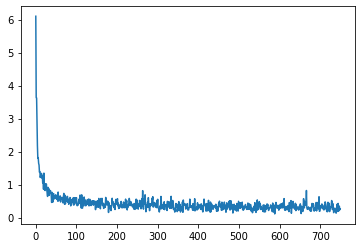

In [99]:
plt.plot(losses) #no wd

0.11175037920475006 0.416656559775273


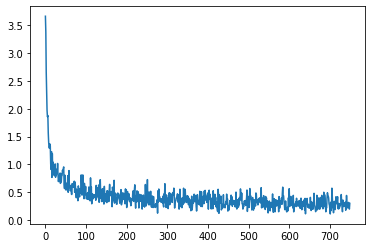

In [102]:
print(min(losses), mean(losses))
plt.plot(losses) # wd = 1e-09

0.10412848740816116 0.4231676478087902 0.3182385622177511


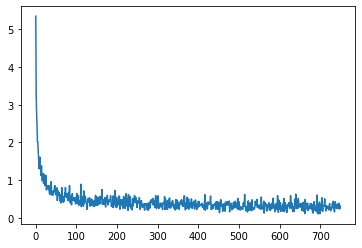

In [106]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-07

0.09025193750858307 0.4119626618127028 0.2579040330939104


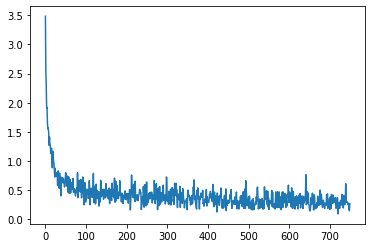

In [108]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-06

0.13397318124771118 0.42521522267659506 0.26959101462445284


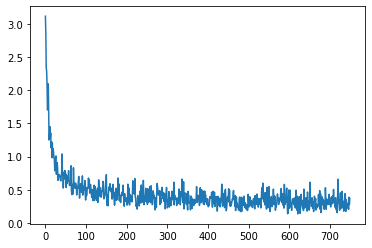

In [115]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-05

0.27292245626449585 0.5679171439806621 0.26584913933794246


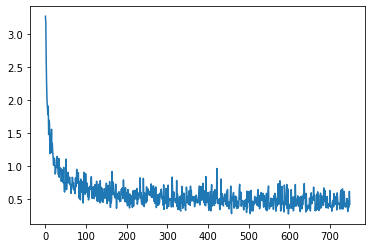

In [26]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-04

1.5511689186096191 1.858455427646637 0.3818671063738492


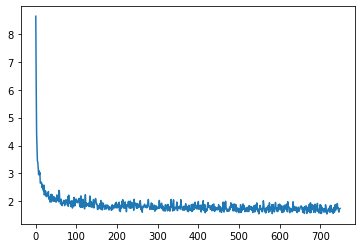

In [119]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-03

In [27]:
model.lin.w.mean(), model.lin.w.std(), model.lin.b.mean(), model.lin.b.std(), model.lin_1.w.mean(), model.lin_1.w.std(), model.lin_1.b.mean(), model.lin_1.b.std(), 

(tensor(-2.2017e-05, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0259, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0193, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0068, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1835, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.2688, device='cuda:0', grad_fn=<StdBackward0>))

In [30]:
 #SGD with Momentum
 class NewLinear(MyLinear):
  def __init__(self, ni, no):
    super().__init__(ni, no)

In [31]:
class MnistNN(nn.Module):
  def __init__(self, ni, no):
    super().__init__()
    self.lin = NewLinear(ni, 500)
    self.lin_1 = NewLinear(500, no)
    # self.lin_2 = MyLinear(100, no, True)
    self.prev_updates = {}
  
  def forward(self, x):
    # res = self.lin_2(F.relu(self.lin_1(F.relu(self.lin(x)))))
    res = self.lin_1(F.relu(self.lin(x)))
    return  res

In [63]:
def update(x, y, lr, wd = 1e-04, p = 0.9):
  yhat = model(x)
  loss = new_loss(yhat, y)

  wsum = 0.0
  for param in model.parameters():
    wsum += (param**2).sum()
  loss += wd*wsum
  loss.backward()

  with torch.no_grad():

    for param in model.parameters():
      update = param.grad
      
      if param.shape in model.prev_updates:
        update = 0.1*update + 0.9*model.prev_updates[param.shape]
      iter_lr = lr*(1/ite)
      param.sub_(lr*update)
      param.grad.zero_()
      model.prev_updates[param.shape] = update
  
  losses.append(loss.item())

In [64]:
losses = []
model = MnistNN(ni, no).cuda()
ite = 1
for x, y in data.train_dl:
  ite += 1
  update(x, y, 1e-01)

0.7728944420814514 2.0829533088207244 1.3175054011535212


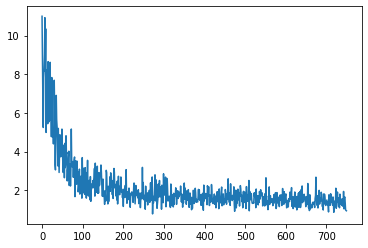

In [65]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) #wd = 1e-0 -- variable learning rates using iter - lr, lr = 1e-01

0.27136099338531494 0.6447892504135767 0.614147063630331


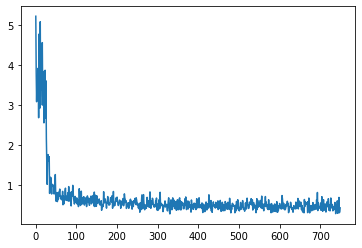

In [61]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) # using regular lr - lr = 1e-02

In [69]:
class NewMnistNN(MnistNN):
  def __init__(self, ni, no):
    super().__init__(ni, no)
    self.prev_grads = {}

In [81]:
#RMSE PROP
def rmse_prop_update(x, y, lr, wd = 1e-04, p = 0.9, rmse_prop = 0.9):
  yhat = model(x)
  loss = new_loss(yhat, y)

  wsum = 0.0
  for param in model.parameters():
    wsum += (param**2).sum()
  loss += wd*wsum
  loss.backward()

  with torch.no_grad():

    for param in model.parameters():
      update = param.grad
      
      #RMSE PROP
      if param.shape in model.prev_grads:
        exp_grad_avg = model.prev_grads[param.shape]
        exp_grad_avg = (1 - rmse_prop)*(update**2) + rmse_prop*exp_grad_avg
        update = update/exp_grad_avg.sqrt()
      else:
        exp_grad_avg = update**2

      param.sub_(lr*update)
      param.grad.zero_()
      model.prev_grads[param.shape] = exp_grad_avg
  
  losses.append(loss.item())

In [113]:
losses = []
model = NewMnistNN(ni, no).cuda()
ite = 1
for x, y in data.train_dl:
  ite += 1
  rmse_prop_update(x, y, 1e-03, rmse_prop=0.99)

0.09106899797916412 0.4633883821864923 0.37811011952901846


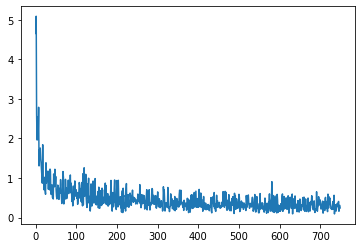

In [86]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) # using regular lr - lr = 1e-03, rmse_prop = 0.1

0.0923345685005188 0.4657277970314026 0.36958987489474016


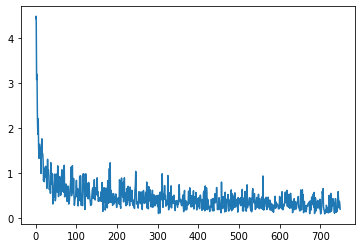

In [88]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.2

0.08610330522060394 0.43415313948194184 0.37126698958533977


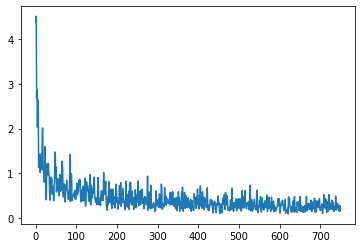

In [90]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.5

0.09517037123441696 0.4201432138880094 0.409392741633889


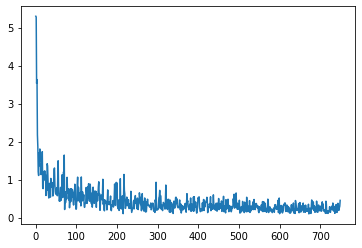

In [92]:
print(min(losses), mean(losses), stdev(losses))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.8

0.08758990466594696 0.4193512256542842 0.5063254091817029 520


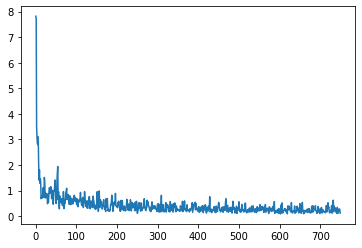

In [112]:
import statistics
mean_l = statistics.mean(losses)
print(min(losses), statistics.mean(losses), stdev(losses), len([i for i in losses if i < mean_l]))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.9

0.11926998943090439 0.438282425036033 0.578932297012529 534


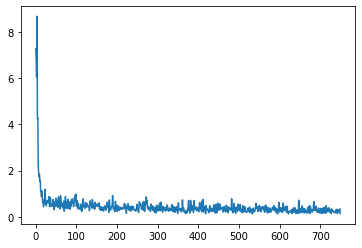

In [114]:
import statistics
mean_l = statistics.mean(losses)
print(min(losses), statistics.mean(losses), stdev(losses), len([i for i in losses if i < mean_l]))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.99

In [119]:
#adam implementation....
#RMSE PROP AND MOMENTUM
#RMSE PROP
def adam_update(x, y, lr, wd = 1e-04, p = 0.9, rmse_prop = 0.9):
  yhat = model(x)
  loss = new_loss(yhat, y)

  wsum = 0.0
  for param in model.parameters():
    wsum += (param**2).sum()
  loss += wd*wsum
  loss.backward()

  with torch.no_grad():

    for param in model.parameters():
      update = param.grad
      #RMSE PROP
      if param.shape in model.prev_grads:
        exp_grad_avg = model.prev_grads[param.shape]
        exp_grad_avg = 0.1*(update**2) + 0.9*exp_grad_avg
        update = update/exp_grad_avg.sqrt()
      else:
        exp_grad_avg = update**2
      #MOMENTUM
      if param.shape in model.prev_updates:
        update = (1 - p) * update + p*model.prev_updates[param.shape]

      param.sub_(lr*update)
      param.grad.zero_()
      model.prev_grads[param.shape] = exp_grad_avg
      model.prev_updates[param.shape] = update
  
  losses.append(loss.item())

In [122]:
losses = []
model = NewMnistNN(ni, no).cuda()
ite = 1
for x, y in data.train_dl:
  ite += 1
  adam_update(x, y, 1e-03, rmse_prop=0.99)

0.09682159125804901 0.4030585660537084 0.3812542677415491 496


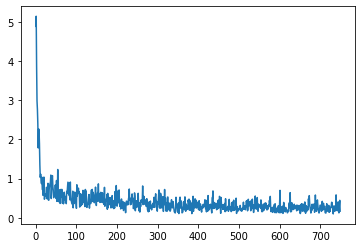

In [123]:
import statistics
mean_l = statistics.mean(losses)
print(min(losses), statistics.mean(losses), stdev(losses), len([i for i in losses if i < mean_l]))
plt.plot(losses) # using regular lr - lr = 1e-01, rmse_prop = 0.99, p = 0.9